In [6]:
import numpy as np
import _pickle as pickle
import gym
import time
import matplotlib.pyplot as plt
import os
from matplotlib import animation

# hyperparameters
hidden_layer_neurons = 200
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-3
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
game_dimensions = 80 * 80 # input dimensionality: 80x80 grid

In [9]:
#TODO: With sqroot, paddle explores more of the board. Why is that?

try:
    with open("ControlRRLR1e-3.txt", "rb") as fp:   # Unpickling
        running_rewards = pickle.load(fp)
    resume = True
except:
    running_rewards = []

if resume:
    model = pickle.load(open('save.p', 'rb')) #This allows you to resume training
else:
    model = {}
    model['W1'] = np.random.randn(hidden_layer_neurons, game_dimensions) / np.sqrt(game_dimensions) # "Xavier" initialization. Idea is to set the initial and output variance to be the same so vanishing/exploding gradient doesn't happen
    #Weights live in the connections. Which is why the weights are 200 by 6400 because that is the total number of connections
    model['W2'] = np.random.randn(hidden_layer_neurons) / np.sqrt(hidden_layer_neurons)
    #Stores 200 weights

In [11]:
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def relu(x):
    if x < 0:
        return 0
    return x

def tanh(x):
    return np.tanh(x)

def softmax(x): 
    pass

def save_frames_as_gif(frames, filename):
    """
    Save a list of frames as a gif
    """ 
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename:
        anim.save(filename, dpi=72, writer='imagemagick')

#TODO: I wonder if we can play around with the downsampling. If you get an error, you need to adjust the game dimensions
#Just see the other number (if you do ::3 then it will be 2916) and take the square root. Then, use replace that
#number with the numbers in the game_dimensions variable

def prepro(input_frame):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    input_frame = input_frame[34:194] # crop
    input_frame = input_frame[::2,::2,0] # downsample by factor of 2 (halves the resolution of the image)
    #This takes every other pixel in the image
    input_frame[input_frame == 144] = 0 # erase background (background type 1)
    input_frame[input_frame == 109] = 0 # erase background (background type 2)
    input_frame[input_frame != 0] = 1 # everything else (paddles, ball) just set to 1
    return input_frame.astype(np.float).ravel()

#TODO: Play around with gamma values

def discount_rewards(rewards):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(rewards)
    running_add = 0
    # print(rewards)  r is a 2d array with the given rewards
    for t in reversed(range(0, rewards.size)):
        if rewards[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + rewards[t]
        discounted_r[t] = running_add
    return discounted_r

# TODO: look into adding bias
def policy_forward(change_in_frame):
    hidden_layer_values = np.dot(model['W1'], change_in_frame)
    hidden_layer_values[hidden_layer_values<0] = 0 # ReLU nonlinearity
    log_probability = np.dot(model['W2'], hidden_layer_values)
    up_prob = sigmoid(log_probability)
    return up_prob, hidden_layer_values # return probability of taking action 2, and hidden state

In [12]:
# TODO: understand and rename (if needed) dh
# dC_dw1: derivative of the cost / derivative of the weights 1 --> partial derivative
# dC_dw2: derivative of the cost / derivative of the weights 2 --> partial derivative
#comb_ep_hidden_layer_values.T and dh.T are the transposed matrices of comb_ep_hidden_layer_values and dh, respectively
def policy_backward(comb_ep_hidden_layer_values, comb_ep_gradient_log_ps):
    """ backward pass. (comb_ep_hidden_layer_values is array of intermediate hidden states) """
    dC_dw2 = np.dot(comb_ep_hidden_layer_values.T, comb_ep_gradient_log_ps).ravel()
    dh = np.outer(comb_ep_gradient_log_ps, model['W2'])
    dh[comb_ep_hidden_layer_values <= 0] = 0 # backpro prelu
    dC_dw1 = np.dot(dh.T, comb_ep_observations) #Why is comb_ep_observations
    return {'W1':dC_dw1, 'W2':dC_dw2}

ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: 1.000000 !!!!!!!!
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -20.000000
ep 1: game finished, reward: -1.000000
ep 1: game finished, reward: -1.000000
ep 1: game finishe

MovieWriter imagemagick unavailable; using Pillow instead.


resetting env. episode reward total was -21.000000. running mean: -20.010000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
ep 2: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -20.019900
ep 3: game finished, reward

KeyboardInterrupt: 

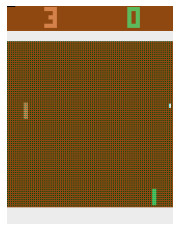

In [17]:
env = gym.make("Pong-v0")
observation = env.reset() # gets very first image of the game
prev_frame = None # used in computing the difference frame 
ep_hidden_layer_values,ep_gradient_log_ps,ep_rewards,ep_change_in_frames = [],[],[],[]
running_reward = None
reward_sum = 0
recordings = [1, 300, 1000, 3000, 6000]
temp = 1
episode_number = 0
count = 0
frames = []

while True:
    if render: 
        env.render()
        #time.sleep(0.1)
    
    if len(running_rewards) in recordings:
        count += 1

    # preprocess the observation, set input to network to be difference image
    curr_frame = prepro(observation)
    change_in_frame = curr_frame - prev_frame if prev_frame is not None else np.zeros(game_dimensions)
    prev_frame = curr_frame
    
    if count <= 301 and count != 0:
        frames.append(observation)
    
    # forward the policy network and sample an action from the returned probability
    up_prob, hidden_layer_values = policy_forward(change_in_frame)
    action = 2 if np.random.uniform() < up_prob else 3 # roll the dice! Generates random probability. This is used for exploring

    #2 means up and 3 means down

    # record various intermediates (needed later for backprop)
    ep_change_in_frames.append(change_in_frame) # observation
    ep_hidden_layer_values.append(hidden_layer_values) # hidden state
    y = 1 if action == 2 else 0 # a "fake label". Our paddle only take the values of 2 and 3 so we need this.
    ep_gradient_log_ps.append(y - up_prob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    #Stores error which is error of the cost

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action) #This is where we tell our paddle to move up or down
    reward_sum += reward

    ep_rewards.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        comb_ep_observations = np.vstack(ep_change_in_frames)
        comb_ep_hidden_layer_values = np.vstack(ep_hidden_layer_values)
        comb_ep_gradient_log_ps = np.vstack(ep_gradient_log_ps)
        comb_ep_rewards = np.vstack(ep_rewards)
        ep_hidden_layer_values,ep_gradient_log_ps,ep_rewards,ep_change_in_frames = [],[],[],[] # reset array memory

        # compute the discounted reward backwards through time
        discounted_comb_ep_rewards = discount_rewards(comb_ep_rewards) # comb_ep_rewards is an array of the rewards
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_comb_ep_rewards -= np.mean(discounted_comb_ep_rewards) # calculates mean and subtracts from each value
        discounted_comb_ep_rewards /= np.std(discounted_comb_ep_rewards)

        comb_ep_gradient_log_ps *= discounted_comb_ep_rewards # modulate the gradient with advantage (PG magic happens right here.)

        grad = policy_backward(comb_ep_hidden_layer_values, comb_ep_gradient_log_ps)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch. Why?

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

        # boring book-keeping

        if len(running_rewards) > 0:
            running_reward = running_rewards[-1]
        
        if len(running_rewards) != 0:
            temp = 100
        
        if len(frames) > 0:
            save_frames_as_gif(frames, filename = f'karpathyModelEp{len(running_rewards)}.gif')
        
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01 #What is this
        running_rewards.append(running_reward)

        with open("ControlRRLR1e-3.txt", "wb") as fp:   #Pickling
            pickle.dump(running_rewards, fp)

        print ('resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
        if episode_number % temp == 0: pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_frame = None
               
        count = 0
        frames = []
               
        if len(running_rewards) == 6001:
            break
        
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print('ep %d: game finished, reward: %f' % (episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))

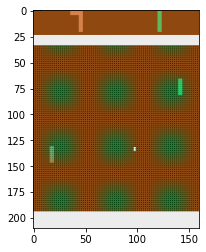

In [27]:
fig = plt.figure()
plt.imshow(observation)
plt.savefig("OriginalImage.png")

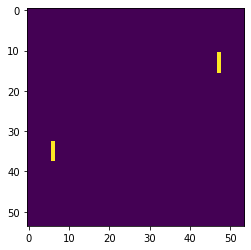

In [28]:
fig1 = plt.figure()
observation = observation[34:194]
observation = observation[::3,::3,0] 
observation[observation == 144] = 0 
observation[observation == 109] = 0 
observation[observation != 0] = 1
plt.imshow(observation)
plt.savefig("NewImage.png")